# Projeto #3 - Análise Exploratória de Dados

Antes de começar, leia as [Instruções](https://github.com/thvmm/pos-ds-ia/blob/master/projeto_3/README.md) e os [Critérios de Avaliação](https://github.com/thvmm/pos-ds-ia/blob/master/projeto_3/README.md).


### 1) **(5%)** Qual a base escolhida e qual seu interesse nela (pode ser mais de uma)? Descrição básica do conjunto de dados escolhido pelo aluno (1 parágrafo).

Estou trabalhando com informações detalhadas reais (parcialmente tratadas para evitar a identificação da empresa) de dez dias de venda de um varejo (aproximadamente 3 milhões de registros). Para exercitar, vou dividir o arquivo em VENDAS e PRODUTOS. Com base nos dados do censo de 2010, a partir do perfil de faixa etária e sexo em BH, será gerada uma base de CLIENTES proporcional ao arquivo do censo. Será criado um arquivo COMPRAS vinculando cada cliente a vários cupons de vendas, para permitir o merge. Ao final da primeira etapa, os 4 dataframes serão mesclados em um único, e as colunas DIADASEMANA e TURNO serão criadas para a investigação. Nos passos intermediários serão gerados arquivos CSV para facilitar eventual reprocessamento futuro. O tratamento inicial dos dados para evitar a identificação da empresa não foi mostrado neste trabalho (remoção de CPFCNPJ de clientes e remoção do nome da empresa dos produtos, entre outros).

O que vc espera descobrir com esse estudo?
* As pessoas fazem mais compras de segunda a sexta ou sábados e domingos? Quais os dias de maior compra?
* Em relação aos produtos ou cestas (produtos comprados juntos):
* Quais são mais vendidos em cada dia da semana?
* E no geral?
* Existe diferença entre manhã (até 11:59:59), tarde (até 17:59:59) e noite?
* Existe diferença se observarmos a idade ou sexo do cliente?


# Achei mais fácil colocar os comentários ao longo do trabalho. Análises, etapas realizadas.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from bisect import bisect
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# essa função foi útil para verificar nulos, nomes de colunas e outras informações para cada arquivo
def Descreve(nome, df):
    df.to_csv('arq_' + nome.lower() + '.csv', index=False)
    print('\n', nome)
    print('\nInformações\n', df.info)
    print('\nResumo\n', df.describe())
    # Verifica valores nulos
    print('\n', '*'*20, 'Contagem de nulos em', nome, '*'*20, '\n', df.isnull().sum())
    
# função para converter a hora da compra em turno
def Turno(hora):
    turnos = [('Manhã' , 12), ('Tarde', 18), ('Noite', 24)]
    return turnos[bisect([i[1] for i in turnos], int(hora))][0]

# função para evitar divisão por zero!
def CalculaMargem(x, y):
    try:
        return (x - y)/ x
    except:
        return 0

### 3) **(20%)** Preparação de dados

Hora de deixar a base perfeita para se trabalhar. Limpe os dados, integre com outras fontes e transforme-o para ficar pronto para se trabalhar! No fim, mostre um antes e depois de seu dataframe.

### 3.1 - Separa arquivos de produtos e vendas com base em dados reais de venda

In [2]:
# Na sequência será realizado MERGE dos dois arquivos. Somente para treinar desmembrar e juntar arquivos.

# carrega vendas de 01 a 10 de março de 2019: na verdade são mais de 3 milhões de registros, meu computador não deu conta...
# isso limitou as análises, porque buscou dados de poucos dias
n_rows = 400000
df = pd.read_csv('Venda_010319_100319.txt', sep=';', decimal=',', encoding='iso-8859-1', nrows=n_rows)

# separa arquivo de VENDAS
cols = ['DATA_VENDA', 'HORA', 'NUMERODF', 'SEQPRODUTO', 'QUANTIDADE']
df_vendas = df[cols].sort_values(cols)
df_vendas.columns = ['data', 'hora', 'cupom', 'sku', 'qtde']
df_vendas['qtde'] = df_vendas['qtde'].apply(lambda x: round(x, 2) if isinstance(x, float) else round(float(x.replace(',', '.')), 2))

# trata campos NaN - excluir
#df_vendas.dropna(inplace=True)

Descreve('Vendas', df_vendas)


 Vendas

Informações
 <bound method DataFrame.info of                               data  hora  cupom     sku  qtde
293578  2019-03-01-00.00.00.000000     6  19188   22150  1.00
293579  2019-03-01-00.00.00.000000     6  24069   15451  0.57
229662  2019-03-01-00.00.00.000000     6  96124   83874  1.00
229663  2019-03-01-00.00.00.000000     6  96125  131267  1.00
229664  2019-03-01-00.00.00.000000     6  97069    5104  1.00
...                            ...   ...    ...     ...   ...
396351  2019-03-02-00.00.00.000000    18  35207   26793  0.25
396350  2019-03-02-00.00.00.000000    18  35207  142723  1.27
396354  2019-03-02-00.00.00.000000    18  35208    1853  1.66
396352  2019-03-02-00.00.00.000000    18  35208    8523  0.73
396353  2019-03-02-00.00.00.000000    18  35208  133695  0.98

[400000 rows x 5 columns]>

Resumo
                 hora          cupom           sku           qtde
count  400000.000000  400000.000000  400000.00000  400000.000000
mean       14.660623   53694.69552

In [3]:
# separa arquivo de PRODUTOS
df['DESCRICAO'] = df['DESCRICAO'].str.lower()
df['DESCRICAO'] = df['DESCRICAO'].str.replace('oba', '')
df['DESCRICAO'] = df['DESCRICAO'].str.strip()
campos = ['SEQPRODUTO', 'DESCRICAO', 'VALOR', 'CUSTO_LIQUIDO_CALCULADO']
df_produtos = df[campos].sort_values(campos).drop_duplicates(keep='last')
df_produtos.drop_duplicates(subset=['DESCRICAO'], keep='last', inplace=True)
df_produtos.drop_duplicates(subset=['SEQPRODUTO'], keep='last', inplace=True)
df_produtos.columns = ['sku', 'produto', 'preco', 'custo']
df_produtos['preco'] = df_produtos['preco'].apply(lambda x: round(x, 2) if isinstance(x, float) else round(float(x.replace(',', '.')), 2))
df_produtos['custo'] = df_produtos['custo'].apply(lambda x: round(x, 2) if isinstance(x, float) else round(float(x.replace(',', '.')), 2))

df_produtos['margem'] = [CalculaMargem(x, y) * 100 for x, y in zip(df_produtos['preco'], df_produtos['custo'])]

# trata campos NaN - excluir
df_produtos.dropna(inplace=True)

Descreve('Produtos', df_produtos)


 Produtos

Informações
 <bound method DataFrame.info of            sku                                      produto  preco  custo  \
319760      66                            abobora italia kg   9.93   2.55   
255389      68                                    acelga un   9.98   1.79   
296662      72                                 beterraba kg   9.21   1.52   
309033      74                                    cebola kg   9.98   2.31   
295789      75                         cebola p conserva kg   8.24   4.18   
...        ...                                          ...    ...    ...   
380851  204860       molho pesto it sacla c manjericao 190g  16.99   7.69   
342616  204870                         salsicha eder c alho  12.07  17.15   
390062  204872                      salsicha aperitivo eder   9.57  17.15   
382973  204874  mexilhao desconchado premier pesc cong 400g  29.99  14.52   
328515  204877      file pescada premier pesc bca cong 400g  65.98  17.10   

           margem 

### 3.2 - Cria arquivo de clientes com base no censo de BH (2010)

In [4]:
# Fonte; https://censo2010.ibge.gov.br/sinopse/webservice/frm_piramide.php?codigo=310620&corhomem=3d4590&cormulher=9cdbfc

# busca dados da população de BH, censo de 2010 (dados da fonte acima repassados para o Excel)
df_bh = pd.read_excel('bh_faixa_etaria.xlsx')

# filtra idade dos clientes entre 20 e 79 anos
faixas = ['20 a 24 anos', '25 a 29 anos', '30 a 34 anos', '35 a 39 anos', '40 a 44 anos', '45 a 49 anos', '50 a 54 anos', '55 a 59 anos', '60 a 64 anos', '65 a 69 anos', '70 a 74 anos', '75 a 79 anos']
df_bh = df_bh[df_bh['faixa_etaria'].isin(faixas)]

# cria lista com população de BH separada por faixa etária e sexo
lista_populacao = list()
for linha, i in zip(df_bh.T.to_dict().items(), range(len(df_bh))):
    lista_populacao.append([linha[1]['faixa_etaria'], 'male', linha[1]['homem']])
    lista_populacao.append([linha[1]['faixa_etaria'], 'female', linha[1]['mulher']])

# cria dataframe da população para gráfico
df_populacao = pd.DataFrame(lista_populacao, columns=['faixa_etaria', 'sexo', 'total'])
df_populacao['percentual'] = df_populacao['total'] / df_populacao['total'].sum()
df_populacao['origem'] = 'populacao'
df_populacao

faixa_etaria    sexo   total  percentual     origem
0   20 a 24 anos    male  106240    0.062596  populacao
1   20 a 24 anos  female  112538    0.066307  populacao
2   25 a 29 anos    male  110707    0.065228  populacao
3   25 a 29 anos  female  120055    0.070736  populacao
4   30 a 34 anos    male  102211    0.060223  populacao
5   30 a 34 anos  female  111603    0.065756  populacao
6   35 a 39 anos    male   84424    0.049742  populacao
7   35 a 39 anos  female   94405    0.055623  populacao
8   40 a 44 anos    male   78564    0.046290  populacao
9   40 a 44 anos  female   90757    0.053474  populacao
10  45 a 49 anos    male   75266    0.044347  populacao
11  45 a 49 anos  female   89662    0.052829  populacao
12  50 a 54 anos    male   66370    0.039105  populacao
13  50 a 54 anos  female   81578    0.048066  populacao
14  55 a 59 anos    male   52018    0.030649  populacao
15  55 a 59 anos  female   66901    0.039418  populacao
16  60 a 64 anos    male   39958    0.023543  populacao
17  60 a 64 anos  female   53230    0.031363  populacao
18  65 a 69 anos    male   28991    0.017081  populacao
19  65 a 69 anos  female   40022    0.023581  populacao
20  70 a 74 anos    male   21442    0.012634  populacao
21  70 a 74 anos  female   31962    0.018832  populacao
22  75 a 79 anos    male   14504    0.008546  populacao
23  75 a 79 anos  female   23814    0.014031  populacao

In [5]:
# cria dataframe da amostra para gráfico: proporcionalidade
tamamanho_amostra = 1000
df_amostra = df_populacao[['faixa_etaria', 'sexo', 'percentual']]
df_amostra['total'] = round(df_amostra['percentual'] * tamamanho_amostra).astype(int)
df_amostra['origem'] = 'cliente proporcionalidade'

# cria dataframe de clientes
lista_clientes = list()
for indice, linha in df_amostra.iterrows():
    for i in range(linha['total']):
        lista_clientes.append(['Cliente ' + str(indice+1) + '-' + str(i+1), linha['faixa_etaria'], linha['sexo']])

df_clientes = pd.DataFrame(lista_clientes, columns=['nome', 'faixa_etaria', 'sexo'])
Descreve('Clientes', df_clientes)


 Clientes

Informações
 <bound method DataFrame.info of                nome  faixa_etaria    sexo
0       Cliente 1-1  20 a 24 anos    male
1       Cliente 1-2  20 a 24 anos    male
2       Cliente 1-3  20 a 24 anos    male
3       Cliente 1-4  20 a 24 anos    male
4       Cliente 1-5  20 a 24 anos    male
...             ...           ...     ...
996   Cliente 24-10  75 a 79 anos  female
997   Cliente 24-11  75 a 79 anos  female
998   Cliente 24-12  75 a 79 anos  female
999   Cliente 24-13  75 a 79 anos  female
1000  Cliente 24-14  75 a 79 anos  female

[1001 rows x 3 columns]>

Resumo
                 nome  faixa_etaria    sexo
count           1001          1001    1001
unique          1001            12       2
top     Cliente 7-34  25 a 29 anos  female
freq               1           136     540

 ******************** Contagem de nulos em Clientes ******************** 
 nome            0
faixa_etaria    0
sexo            0
dtype: int64


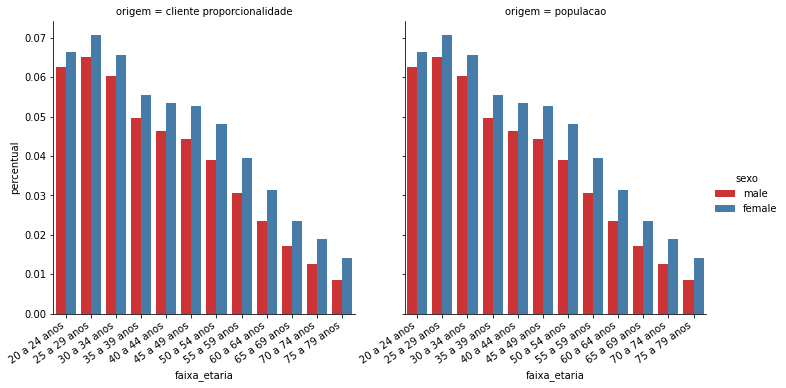

In [6]:
# cria gráfico amostra
df_grafico = pd.concat([df_amostra, df_populacao])
grafico = sns.catplot(data=df_grafico, x='faixa_etaria', y='percentual', kind='bar', hue='sexo', palette='Set1', col='origem')
grafico.set_xticklabels(rotation=35, horizontalalignment='right')

df_clientes.to_csv('arq_clientes.csv', index=False)

### 3.3 - Concatena Vendas e Produtos

In [7]:
df_vendas = pd.read_csv('arq_vendas.csv') #, nrows=10000)
df_produtos = pd.read_csv('arq_produtos.csv') #, nrows=10000)

df_completo = pd.merge(df_vendas, df_produtos, how='inner', on='sku').sort_values(['data', 'hora', 'cupom', 'produto'])

# cria novas colunas
df_completo['lucro'] = df_completo['preco'] - df_completo['custo']

for campo in ['preco', 'custo', 'lucro']:
  df_completo[campo + '_total'] = df_completo['qtde'] * df_completo[campo]

df_completo['data'] = df_completo['data'].str[:10]
df_completo['dia_semana'] = pd.to_datetime(df_completo['data']).dt.day_name()

df_completo['horario'] = [Turno(x) for x in df_completo['hora']]

# corrige formatos e caracteres especiais
df_completo['cupom'] = df_completo['cupom'].astype('str')
df_completo['produto'] = df_completo['produto'].str.replace('&', '-').replace('/', '')

Descreve('Completo', df_completo)


 Completo

Informações
 <bound method DataFrame.info of               data  hora  cupom     sku  qtde  \
0       2019-03-01     6  19188   22150  1.00   
2       2019-03-01     6  24069   15451  0.57   
6436    2019-03-01     6  96124   83874  1.00   
6483    2019-03-01     6  96125  131267  1.00   
6490    2019-03-01     6  97069    5104  1.00   
...            ...   ...    ...     ...   ...   
161261  2019-03-02    18  35207  142723  1.27   
134721  2019-03-02    18  35207   26793  0.25   
87472   2019-03-02    18  35208    1853  1.66   
194352  2019-03-02    18  35208    8523  0.73   
159982  2019-03-02    18  35208  133695  0.98   

                                  produto  preco  custo      margem  lucro  \
0                         lc comp morango   0.01   0.00  100.000000   0.01   
2                             pao frances   9.98   6.51   34.769539   3.47   
6436                       crisantemo mix  37.98   9.00   76.303318  28.98   
6483    coalhada verde campo lacfree 140g 

### 3.4 - Atribui clientes a cupons de venda

In [8]:
df_clientes = pd.read_csv('arq_clientes.csv') #, nrows=10000)

# atribui clientes a cupons
cupons = df_completo[['cupom']].groupby('cupom')

clientes = list()
for cupom, indices in cupons.groups.items():
    # RANDOM>CHOICE - processo totalmente aleatório, não permite conclusões sensatas...
    clientes.append([cupom, random.choice(df_clientes['nome'])])  
clientes = pd.DataFrame(clientes, columns=['cupom', 'nome'])

# concatena dataframe completo com nome do cliente
df_completo = pd.merge(df_completo, clientes, how='inner', on='cupom')

# totaliza cupons
total_cupons = df_completo[['cupom', 'preco_total']].groupby('cupom').sum().reset_index()
total_cupons.columns = ['cupom', 'total_cupom']
total_cupons['total_cupom'] = round(total_cupons['total_cupom'], 2)

# concatena dataframe completo com valor total do cupom
df_completo = pd.merge(df_completo, total_cupons, how='inner', on='cupom')

# concatena dataframe completo (vendas MERGE produtos) com clientes
df_completo = pd.merge(df_completo, df_clientes, how='inner', on='nome')
#print(df_completo)

Descreve('Completo', df_completo)


 Completo

Informações
 <bound method DataFrame.info of               data  hora  cupom     sku  qtde  \
0       2019-03-01     6  19188   22150  1.00   
1       2019-03-01    12  19188    1808  0.66   
2       2019-03-01    12  19188  181870  1.00   
3       2019-03-01    12  19188    2471  1.00   
4       2019-03-01    12  19188    2780  0.08   
...            ...   ...    ...     ...   ...   
389644  2019-03-02    16  48185  144341  1.00   
389645  2019-03-02    16  48185  144362  1.00   
389646  2019-03-02    16  48185    2241  1.24   
389647  2019-03-02    16  48185    2689  0.72   
389648  2019-03-02    16  48185    4002  0.16   

                                                  produto  preco  custo  \
0                                         lc comp morango   0.01   0.00   
1                                        banana nanica kg   9.98   2.33   
2       mac la molisana fusilloni super ext di lusso 500g  35.97   4.92   
3                                        mostarda maco

In [9]:
# cria completo por cupom
df_completo_cupons = df_completo[['data', 'hora', 'cupom', 'dia_semana', 'horario', 'nome', 'total_cupom', 'faixa_etaria', 'sexo']].drop_duplicates()

Descreve('Completo_cupons', df_completo_cupons)


 Completo_cupons

Informações
 <bound method DataFrame.info of               data  hora   cupom dia_semana horario          nome  \
0       2019-03-01     6   19188     Friday   Manhã  Cliente 6-57   
1       2019-03-01    12   19188     Friday   Tarde  Cliente 6-57   
6       2019-03-01    16   19188     Friday   Tarde  Cliente 6-57   
8       2019-03-01     7    7554     Friday   Manhã  Cliente 6-57   
11      2019-03-01    17    7554     Friday   Tarde  Cliente 6-57   
...            ...   ...     ...        ...     ...           ...   
389587  2019-03-01    21  113721     Friday   Noite  Cliente 8-45   
389593  2019-03-01    21  119772     Friday   Noite  Cliente 8-45   
389597  2019-03-02    15   11747   Saturday   Tarde  Cliente 8-45   
389609  2019-03-02    16   43853   Saturday   Tarde  Cliente 8-45   
389612  2019-03-02    16   48185   Saturday   Tarde  Cliente 8-45   

        total_cupom  faixa_etaria    sexo  
0            147.90  30 a 34 anos  female  
1            147.90

### 4) **(30%)** Análise

Com seu dado pronto, é hora de fazer a parte mais legal: investigar e responder nossas hipoteses. Elas se confirmam? Em quais cenários? Existe alguma forma de perceber isso no mundo real? Dica: Abuse das técnicas de visualização.

Ex: Ainda no contexto dos exemplos do item 2). Ao investigar a hipotese relacionada ao padrão de compra, percebi que em todos os meses existia uma diferença entre dia util e final de semana. Porém notei que Fevereiro possui um comportamento diferente, o que poderia explicar? Talvez o carnaval e seus feriados.

Ex2: Talvez eu descubra que alguns finais de semana possuam um comportamento diferente dos dias de semana e outros não. Por que não são todos? Nessa investigação você pode acabar descobrindo que os finais de semana que são diferentes, coincidem no fato de serem os primeiros dias utéis, o que pode remeter ao fato de boa parte das empresas realizarem pagamentos nessa parte do mês.

In [10]:
# Implemente sua análise aqui. Use mais blocos se achar que ficará mais organizado.
fig = px.scatter(df_produtos[df_produtos['margem'] > -1000], x='preco', y='margem', title='Preço x Margem', color='custo', size='preco', hover_data=['produto'], range_y=[df_produtos[df_produtos['margem'] > -1000]['margem'].min()*1.1, 110])
fig.show()

# Esse gráfico ficou interessante para mostrar os produtos com preço menor que o custo.
# ESsa informação exigiu o detalhamento dos dados com algum especialista, pois a princípio os dados originais vieram de um PDV, e nÃo seria o caso de erros de digitação...

In [11]:
df_produtos[df_produtos['margem'] <= -1000].sort_values(['margem'])

# a análise inicial mostrou produtos em promoçÃo ou perto da data de vencimento.
# o caso mais estranho foi da máquina de café, com custo alto (162.22) em relaçÃo ao preço (0.01). Na verdade, a promoção era "compre X produtos e leve a máquina de brinde"

sku                              produto  preco   custo        margem
8085  181343  maq deltaq qool evolution verm 127v   0.01  162.62 -1.626100e+06
4378   72339       bisc sta farina leite ninho kg   0.40   31.75 -7.837500e+03
3877   25570          confeito borussia kg banana   0.45   26.97 -5.893333e+03
3379   20550                lc cha sabores xicara   4.99  282.10 -5.553307e+03
4995  130400                     framboesa bdj kg   9.95  165.00 -1.558291e+03

In [12]:
df_produtos.describe()

sku        preco        custo        margem
count    9178.000000  9178.000000  9178.000000  9.178000e+03
mean    88456.126062    24.390984    10.271081 -1.349994e+02
std     75373.175841    32.199117    13.661156  1.697457e+04
min        66.000000     0.010000     0.000000 -1.626100e+06
25%      9899.500000     7.990000     3.040000  4.167989e+01
50%     95129.000000     9.990000     6.000000  5.570847e+01
75%    154569.750000    29.990000    12.307500  7.595437e+01
max    204877.000000   989.430000   282.100000  1.000000e+02

In [13]:
# verifica distribuição das vendas por dia da semana e sexo
fig = px.violin(df_completo_cupons, x='dia_semana', y='total_cupom', title='Total Cupom x Idade', color='sexo')
fig.show()

# A princípio alguns valores chamaram a atençao por estarem bem longe da média, e de um valor mais "comum" para despesas de supermercado (valores acima de 10 mil reais)
# O levantamento permitiu concluir que alguns clientes (principalmente restaurantes) fazem compras diárias e acertam uma vez por semana, gerando um valor alto como se fosse uma única compra

In [14]:
df_completo_cupons.sort_values(['total_cupom'], ascending=False)

data  hora   cupom dia_semana horario           nome  \
187317  2019-03-01    17  185729     Friday   Tarde   Cliente 20-3   
223467  2019-03-01    12   13275     Friday   Tarde    Cliente 7-1   
162234  2019-03-01    10  185614     Friday   Manhã   Cliente 3-16   
323326  2019-03-01     8    5258     Friday   Manhã   Cliente 2-14   
323350  2019-03-01    15    5258     Friday   Tarde   Cliente 2-14   
...            ...   ...     ...        ...     ...            ...   
108002  2019-03-01    15   44497     Friday   Tarde   Cliente 2-52   
269016  2019-03-01    21  126455     Friday   Noite  Cliente 10-43   
40814   2019-03-01    20  119756     Friday   Noite   Cliente 6-12   
271845  2019-03-01    16  119669     Friday   Tarde   Cliente 4-37   
320613  2019-03-01    13  136378     Friday   Tarde   Cliente 6-30   

        total_cupom  faixa_etaria    sexo  
187317     70990.90  65 a 69 anos  female  
223467     51927.27  35 a 39 anos    male  
162234     13286.64  25 a 29 anos    male  
323326     12763.97  20 a 24 anos  female  
323350     12763.97  20 a 24 anos  female  
...             ...           ...     ...  
108002         0.29  20 a 24 anos  female  
269016         0.10  40 a 44 anos  female  
40814          0.10  30 a 34 anos  female  
271845         0.10  25 a 29 anos  female  
320613         0.00  30 a 34 anos  female  

[58534 rows x 9 columns]

In [15]:
df_completo[df_completo['total_cupom'] > 10000]

# No detalhamento foram identificadas as compras acima de 10 mil.
# Alguns valores estranhos ainda precisavam de análise, como 448.53 pelo quilo de carne suína, mas não houve tempo para esse detalhamento

data  hora cupom     sku  qtde  \
48717   2019-03-01    10  5264     917   1.1   
48718   2019-03-01    10  5264   16067   1.0   
48719   2019-03-01    10  5264    2180  10.0   
48720   2019-03-01    10  5264    3046   2.0   
48721   2019-03-01    10  5264     454  48.0   
...            ...   ...   ...     ...   ...   
323349  2019-03-01     8  5258    4602   1.0   
323350  2019-03-01    15  5258  146592   2.0   
323351  2019-03-01    15  5258   75834   1.0   
323352  2019-03-01    15  5258   35345   1.0   
323353  2019-03-01    15  5258  144844   2.0   

                                    produto  preco  custo     margem  lucro  \
48717               abobora italiana ext kg   9.96   2.73  72.590361   7.23   
48718                 achoc nescau 400g 2.0   7.99   4.45  44.305382   3.54   
48719                  achoc toddynho 200ml   8.37   1.51  81.959379   6.86   
48720     acucar uniao refinado 1k especial   8.97   1.90  78.818283   7.07   
48721         agua min bonafont 500ml s gas  95.52   1.24  98.701843  94.28   
...                                     ...    ...    ...        ...    ...   
323349               sal cisne refinado 1kg   5.98   1.55  74.080268   4.43   
323350  cerv heilige bohemian pilsner 500ml  50.97  10.58  79.242692  40.39   
323351       cerv nac backer pale ale 600ml  16.99   9.90  41.730430   7.09   
323352         cerv nac backer pilsen 600ml   9.90   7.70  22.222222   2.20   
323353    cerv pol edelmeister weizen 500ml   9.98   6.95  30.360721   3.03   

        preco_total  custo_total  lucro_total dia_semana horario  \
48717        10.956        3.003        7.953     Friday   Manhã   
48718         7.990        4.450        3.540     Friday   Manhã   
48719        83.700       15.100       68.600     Friday   Manhã   
48720        17.940        3.800       14.140     Friday   Manhã   
48721      4584.960       59.520     4525.440     Friday   Manhã   
...             ...          ...          ...        ...     ...   
323349        5.980        1.550        4.430     Friday   Manhã   
323350      101.940       21.160       80.780     Friday   Tarde   
323351       16.990        9.900        7.090     Friday   Tarde   
323352        9.900        7.700        2.200     Friday   Tarde   
323353       19.960       13.900        6.060     Friday   Tarde   

                nome  total_cupom  faixa_etaria    sexo  
48717   Cliente 6-55     10524.90  30 a 34 anos  female  
48718   Cliente 6-55     10524.90  30 a 34 anos  female  
48719   Cliente 6-55     10524.90  30 a 34 anos  female  
48720   Cliente 6-55     10524.90  30 a 34 anos  female  
48721   Cliente 6-55     10524.90  30 a 34 anos  female  
...              ...          ...           ...     ...  
323349  Cliente 2-14     12763.97  20 a 24 anos  female  
323350  Cliente 2-14     12763.97  20 a 24 anos  female  
323351  Cliente 2-14     12763.97  20 a 24 anos  female  
323352  Cliente 2-14     12763.97  20 a 24 anos  female  
323353  Cliente 2-14     12763.97  20 a 24 anos  female  

[245 rows x 19 columns]

In [16]:
# verifica distribuição das vendas por faixa etária e sexo
fig = px.violin(df_completo_cupons[df_completo_cupons['total_cupom'] < 10000].sort_values('faixa_etaria'), x='faixa_etaria', y='total_cupom', title='Total Cupom x Idade', color='sexo')
fig.show()

# A distribuição por sexo, eliminados os cupons de mais de 10 mil, pode ser interessante para análise gerencial, mas nesse caso os dados de clientes foram aleatórios e nÃo permitem nenhuma conclusão

In [17]:
# verifica distribuição das vendas por faixa etária e sexo
fig = px.violin(df_completo_cupons[df_completo_cupons['total_cupom'] < 10000].sort_values('faixa_etaria'), x='faixa_etaria', y='total_cupom', title='Total Cupom x Dia', color='dia_semana')
fig.show()

# o mesmo vale para as compras por faixa etária e dia da semana. Dado o grande colume de dados, não foi possível fazer a comparação entre diversos dias da semana

### 5) Modelagem 30%

Agora você terá mais uma oportunidade de mostrar o que você aprendeu durante o módulo 2 quanto a modelagem de dados e criação de modelos. Utilizando os dados preparados na seção 1 e após a análise feita na seção 2 você deverá:
1. **Defina um problema de regressão ou classificação que envolva uma variável dos seus dados.**

In [18]:
# O código rodou... está no final do arquivo. Mas interpretar os resultados são outros 500... realmente não consegui ainda aprofundar no estudo dos modelos.
# Ainda estou avançando em relação ao tratamento dos dados, mas senti um desenvolvimento muito grande nessa parte inicial.
# Os gráficos e alguns procedimentos desse trabalho estão sendo incorporados em uma ferramenta comercial simples
# Hoje está bem mais confortável trabalhar com CSV e bancos de dados para tratamento, a ideia geral do projeto está clara, mas ainda não consigo dedicar todo o tempo que gostaria para o estudo do conteúdo apresentado no curso.
# Falta de tempo (interesse existe, e muito!), necessidade de aprofundamento no estudo dos modelos, uso de arquivo muito grande para a capacidade da máquina foram fatores que comprometeram a qualidade final do trabalho: praticamente nenhuma das questões porpostas foram respondidas...
# Por um lado, o trabalho agregou muito valor pela proximidade com minha atuação profissional; por outro, buscarei arquivos menores e tentarei antecipar ao máximo o início do trabalho, já adiantando bem a parte de tratamento, para tirar mais proveito dos modelos

***---> Agrupar produtos vendidos juntos (cesta).***

2. **Realize ao menos 2 técnicas de processamento e seleção de features.**
    * Isto inclui, normalização, PCA, e técnicas de seleção de features como information gain. Seja criativo pois está parte é crucial para seu modelo. Você pode escolhar manualmente as features desde que seja justificada na seção 2 (parte de Análise).


3. **Defina uma métrica para avaliar o seu modelo.**
    * Por exemplo, você pode utilizar MAE (Mean Absolute Error) para um problema de regressão. Ou, F1-Score para um problema de classificação. Há varias métricas, então escolha sabiamente.


***---> Comente brevemente sua decisão aqui.***

4. **Divida seus dados em 2 conjuntos. Um de treino e outro conjunto de teste.**
    * Treine e otimize seu modelo no conjunto de treino e apenas use o conjunto de teste para apresentar os resultados finais.


5. **Treine um ou mais modelos de ML para o seu problema.**
    * Escolha 1 ou mais tipos de classificadores ou regressores dependendo do seu problema.
    * Por exemplo, TreeClassifier para um problema de classificação. 
    * Use cross-validation e outras técnicas como GridSearch e ou RandomizedSearch para encontrar os melhores parametros para o seu modelo.


6. **Apresente (com visualizações) os resultados do seu modelo mostrando que ele é melhor do que um baseline não aleatório.**
    * Para o baseline, você pode escolher um modelo bem trivial mas não aleatório. Por exemplo, para um problema de classificação um baseline pode ser a classe mais presente caso o conjunto de dados seja desbalanceado.  Um modelo mais simples também pode ser utilizado como baseline, por exemplo, você escolheu um Random Forest Classifier, e comparou os resultados um Logistic Regression. Você pode até mesmo escolher um modelo de AutoML(como TPOT) como Baseline.

### 6) Conclusões **10%**

*Partindo das suas hipoteses e investigações, o que você consegue concluir? Suas hipoteses se concretizaram?*

In [19]:
# comprados junto
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

cupons = df_completo[['cupom', 'produto']].sort_values('cupom').groupby('cupom')

compras = list()
for cupom, indices in cupons.groups.items():
    juntos = list()
    for indice in indices:
        juntos.append(df_completo['produto'].iloc[indice])
    compras.append(juntos)
print('Compras', len(compras))

compras_mais_1 = list()
for compra in compras:
    if len(compra) > 1:
        compras_mais_1.append(compra)
print('Compras com no mínimo 2', len(compras_mais_1))

Compras 46011
Compras com no mínimo 2 38563


In [20]:
te = TransactionEncoder()
te_ary = te.fit(compras).transform(compras)
df_transaction = pd.DataFrame(te_ary, columns=te.columns_)
df_transaction.shapete = TransactionEncoder()
te_ary = te.fit(compras).transform(compras)
df_transaction = pd.DataFrame(te_ary, columns=te.columns_)
df_transaction.shape

(46011, 9178)

In [21]:
frequent_itemsets = apriori(df_transaction, min_support=0.01, use_colnames=True)
frequent_itemsets

support                                           itemsets
0    0.046989                                       (abacate kg)
1    0.047315                            (abacaxi perola cortes)
2    0.012932                        (abobora brasileira ext kg)
3    0.017604                          (abobora cabotia desc kg)
4    0.035144                          (abobora italiana ext kg)
..        ...                                                ...
275  0.010041  (mandioquinha ext kg, batata inglesa kg, cenou...
276  0.011280  (batata inglesa kg, tomate italiano kg ext, ce...
277  0.011715  (limao tahiti kg, cebola nacional kg ext, ceno...
278  0.011258  (tomate italiano kg ext, cebola nacional kg ex...
279  0.010845  (limao tahiti kg, tomate italiano kg ext, cebo...

[280 rows x 2 columns]

In [22]:
from mlxtend.frequent_patterns import fpmax
max_itemsets = fpmax(df_transaction, min_support=0.01, use_colnames=True)
max_itemsets

support                                    itemsets
0    0.010171                               (salsinha bj)
1    0.010324                   (laranja pera pacote 5kg)
2    0.010454                               (melancia kg)
3    0.010563                       (ofertao flv  kg 199)
4    0.010606         (q minas frescal mantiqueira pc kg)
..        ...                                         ...
230  0.012845         (banana prata kg, banana nanica kg)
231  0.017148             (pao frances, banana nanica kg)
232  0.020734  (banana nanica kg, cebola nacional kg ext)
233  0.016214       (pao frances, cebola nacional kg ext)
234  0.019582              (banana prata kg, pao frances)

[235 rows x 2 columns]

In [23]:
from mlxtend.frequent_patterns import association_rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.0001)
rules

antecedents  \
0                                        (abacate kg)   
1                                  (banana nanica kg)   
2                                   (banana prata kg)   
3                                        (abacate kg)   
4                                        (abacate kg)   
..                                                ...   
363         (limao tahiti kg, cebola nacional kg ext)   
364  (tomate italiano kg ext, cebola nacional kg ext)   
365                                 (limao tahiti kg)   
366                          (tomate italiano kg ext)   
367                          (cebola nacional kg ext)   

                                          consequents  antecedent support  \
0                                  (banana nanica kg)            0.046989   
1                                        (abacate kg)            0.090087   
2                                        (abacate kg)            0.102758   
3                                   (banana prata kg)            0.046989   
4                                 (batata inglesa kg)            0.046989   
..                                                ...                 ...   
363                          (tomate italiano kg ext)            0.028971   
364                                 (limao tahiti kg)            0.028037   
365  (tomate italiano kg ext, cebola nacional kg ext)            0.087979   
366         (limao tahiti kg, cebola nacional kg ext)            0.075504   
367         (limao tahiti kg, tomate italiano kg ext)            0.090478   

     consequent support   support  confidence      lift  leverage  conviction  
0              0.090087  0.013410    0.285384  3.167865  0.009177    1.273289  
1              0.046989  0.013410    0.148854  3.167865  0.009177    1.119680  
2              0.046989  0.016409    0.159687  3.398408  0.011581    1.134115  
3              0.102758  0.016409    0.349214  3.398408  0.011581    1.378704  
4              0.083263  0.011823    0.251619  3.021988  0.007911    1.224960  
..                  ...       ...         ...       ...       ...         ...  
363            0.075504  0.010845    0.374344  4.957951  0.008658    1.477642  
364            0.087979  0.010845    0.386822  4.396752  0.008379    1.487367  
365            0.028037  0.010845    0.123271  4.396752  0.008379    1.108624  
366            0.028971  0.010845    0.143638  4.957951  0.008658    1.133900  
367            0.021212  0.010845    0.119865  5.650749  0.008926    1.112089  

[368 rows x 9 columns]

In [24]:
rules = association_rules(frequent_itemsets, metric="leverage", min_threshold=0.001)
rules

antecedents  \
0                                        (abacate kg)   
1                                  (banana nanica kg)   
2                                   (banana prata kg)   
3                                        (abacate kg)   
4                                        (abacate kg)   
..                                                ...   
363         (limao tahiti kg, cebola nacional kg ext)   
364  (tomate italiano kg ext, cebola nacional kg ext)   
365                                 (limao tahiti kg)   
366                          (tomate italiano kg ext)   
367                          (cebola nacional kg ext)   

                                          consequents  antecedent support  \
0                                  (banana nanica kg)            0.046989   
1                                        (abacate kg)            0.090087   
2                                        (abacate kg)            0.102758   
3                                   (banana prata kg)            0.046989   
4                                 (batata inglesa kg)            0.046989   
..                                                ...                 ...   
363                          (tomate italiano kg ext)            0.028971   
364                                 (limao tahiti kg)            0.028037   
365  (tomate italiano kg ext, cebola nacional kg ext)            0.087979   
366         (limao tahiti kg, cebola nacional kg ext)            0.075504   
367         (limao tahiti kg, tomate italiano kg ext)            0.090478   

     consequent support   support  confidence      lift  leverage  conviction  
0              0.090087  0.013410    0.285384  3.167865  0.009177    1.273289  
1              0.046989  0.013410    0.148854  3.167865  0.009177    1.119680  
2              0.046989  0.016409    0.159687  3.398408  0.011581    1.134115  
3              0.102758  0.016409    0.349214  3.398408  0.011581    1.378704  
4              0.083263  0.011823    0.251619  3.021988  0.007911    1.224960  
..                  ...       ...         ...       ...       ...         ...  
363            0.075504  0.010845    0.374344  4.957951  0.008658    1.477642  
364            0.087979  0.010845    0.386822  4.396752  0.008379    1.487367  
365            0.028037  0.010845    0.123271  4.396752  0.008379    1.108624  
366            0.028971  0.010845    0.143638  4.957951  0.008658    1.133900  
367            0.021212  0.010845    0.119865  5.650749  0.008926    1.112089  

[368 rows x 9 columns]

In [25]:
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules

antecedents  \
0                                        (abacate kg)   
1                                  (banana nanica kg)   
2                                   (banana prata kg)   
3                                        (abacate kg)   
4                                        (abacate kg)   
..                                                ...   
363         (limao tahiti kg, cebola nacional kg ext)   
364  (tomate italiano kg ext, cebola nacional kg ext)   
365                                 (limao tahiti kg)   
366                          (tomate italiano kg ext)   
367                          (cebola nacional kg ext)   

                                          consequents  antecedent support  \
0                                  (banana nanica kg)            0.046989   
1                                        (abacate kg)            0.090087   
2                                        (abacate kg)            0.102758   
3                                   (banana prata kg)            0.046989   
4                                 (batata inglesa kg)            0.046989   
..                                                ...                 ...   
363                          (tomate italiano kg ext)            0.028971   
364                                 (limao tahiti kg)            0.028037   
365  (tomate italiano kg ext, cebola nacional kg ext)            0.087979   
366         (limao tahiti kg, cebola nacional kg ext)            0.075504   
367         (limao tahiti kg, tomate italiano kg ext)            0.090478   

     consequent support   support  confidence      lift  leverage  conviction  \
0              0.090087  0.013410    0.285384  3.167865  0.009177    1.273289   
1              0.046989  0.013410    0.148854  3.167865  0.009177    1.119680   
2              0.046989  0.016409    0.159687  3.398408  0.011581    1.134115   
3              0.102758  0.016409    0.349214  3.398408  0.011581    1.378704   
4              0.083263  0.011823    0.251619  3.021988  0.007911    1.224960   
..                  ...       ...         ...       ...       ...         ...   
363            0.075504  0.010845    0.374344  4.957951  0.008658    1.477642   
364            0.087979  0.010845    0.386822  4.396752  0.008379    1.487367   
365            0.028037  0.010845    0.123271  4.396752  0.008379    1.108624   
366            0.028971  0.010845    0.143638  4.957951  0.008658    1.133900   
367            0.021212  0.010845    0.119865  5.650749  0.008926    1.112089   

     antecedent_len  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  
..              ...  
363               2  
364               2  
365               1  
366               1  
367               1  

[368 rows x 10 columns]

In [26]:
rules[ (rules['antecedent_len'] >= 0.7) &
       (rules['confidence'] > 0.75) &
       (rules['lift'] > 1) ]

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, antecedent_len]
Index: []

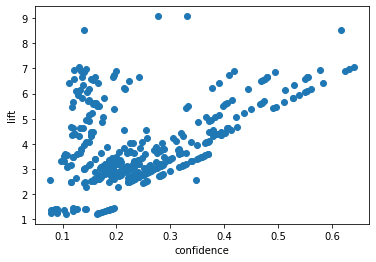

In [27]:
import matplotlib.pyplot as plt
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.007)
scores = rules[['confidence', 'lift']].values
#print(scores)

x = rules['confidence'].values
y = rules['lift'].values

plt.scatter(x, y)
plt.xlabel('confidence')
plt.ylabel('lift')
plt.show()

In [28]:
def identify_pareto(scores):
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' pint is dominated by out 'j' point
            if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]

pareto = identify_pareto(scores)
print ('Pareto front index vales')
print ('Points on Pareto front: \n',pareto)

pareto_front = scores[pareto]
print ('\nPareto front scores')
print (pareto_front)

Pareto front index vales
Points on Pareto front: 
 [279 338 340]

Pareto front scores
[[0.64033019 7.07716366]
 [0.616      8.55243693]
 [0.33023588 9.08217765]]


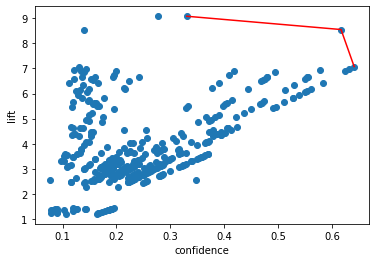

In [29]:
pareto_front_df = pd.DataFrame(pareto_front)
pareto_front_df.sort_values(0, inplace=True)
pareto_front = pareto_front_df.values

x_all = scores[:, 0]
y_all = scores[:, 1]
x_pareto = pareto_front[:, 0]
y_pareto = pareto_front[:, 1]

plt.scatter(x_all, y_all)
plt.plot(x_pareto, y_pareto, color='r')
plt.xlabel('confidence')
plt.ylabel('lift')
plt.show()